# Krafthack 2022 Additive neural newtork model

In [65]:
import pandas as pd
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle

In [60]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

# Set random seed for reproducability
tensorflow.random.set_seed(0)

print("Libraries imported.")
print('Keras version:',keras.__version__)
print('TensorFlow version:',tensorflow.__version__)

Libraries imported.
Keras version: 2.8.0
TensorFlow version: 2.8.0


In [61]:
from data_helpers import get_operating_signal_names, get_tensile_sensor_names
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [62]:
data = pd.read_parquet('../data/detrended_unsteady_data.parquet')

In [63]:
data.head()

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,,,,,,,
1970-09-15 06:56:03,163.100266,90.276807,60.098363,166.064484,5263.947825,107.891071,0.517321,-9.222117,-1.668450,-2.150455,-6.823433,-4.385147
1970-09-15 06:56:04,166.613592,90.988261,60.929913,166.111823,5263.889721,107.893265,1.097723,-8.659779,-1.336758,-2.152363,-6.982280,-3.965735
1970-09-15 06:56:05,169.428142,91.622363,61.539950,166.163542,5263.870461,107.895458,1.089744,-8.906835,-1.736205,-2.544179,-7.110362,-3.948395
1970-09-15 06:56:06,172.034776,92.233450,62.084078,166.216656,5263.863565,107.897652,1.234877,-8.797338,-1.454419,-1.811378,-6.157946,-3.345318
1970-09-15 06:56:07,174.641411,92.844537,62.628207,166.269769,5263.856669,107.899845,1.063184,-8.686581,-1.357872,-1.998880,-6.815910,-3.957044


In [64]:
data = data.dropna()
data = data.drop_duplicates()

In [66]:
input_scaler = StandardScaler().fit(data.loc[:,get_operating_signal_names()].values)

with open('unsteady_data_scaler.pkl','wb') as f:
    pickle.dump(input_scaler,f)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(data.loc[:,get_operating_signal_names()].values,
                                                    data.loc[:,get_tensile_sensor_names()].values,
                                                    test_size=0.20,
                                                    random_state=0)

x_test = input_scaler.transform(x_test)
x_train = input_scaler.transform(x_train)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_test = y_test.astype('float32')
y_train = y_train.astype('float32')

In [98]:
model = keras.Sequential(
    [
        layers.Dense(36, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(36, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(len(get_tensile_sensor_names())),
    ]
)

callback_list = [keras.callbacks.EarlyStopping(monitor="val_mae", patience=3)]
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])

In [99]:
num_epochs = 200
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=15, validation_data=(x_test, y_test))
model.save('unsteady_additive_fitted_model')

Epoch 1/200
6060/6060 [==============================] - 8s 1ms/step - loss: 4.0631 - mae: 1.3898 - val_loss: 2.9003 - val_mae: 1.0578
Epoch 2/200
6060/6060 [==============================] - 6s 1ms/step - loss: 3.1879 - mae: 1.1779 - val_loss: 2.3235 - val_mae: 0.9472
Epoch 3/200
6060/6060 [==============================] - 5s 869us/step - loss: 2.8182 - mae: 1.1211 - val_loss: 1.9247 - val_mae: 0.8997
Epoch 4/200
6060/6060 [==============================] - 5s 825us/step - loss: 2.4877 - mae: 1.0761 - val_loss: 1.6150 - val_mae: 0.8523
Epoch 5/200
6060/6060 [==============================] - 6s 1ms/step - loss: 2.3241 - mae: 1.0399 - val_loss: 1.3776 - val_mae: 0.8003
Epoch 6/200
6060/6060 [==============================] - 6s 1ms/step - loss: 2.1977 - mae: 1.0139 - val_loss: 1.2585 - val_mae: 0.7740
Epoch 7/200
6060/6060 [==============================] - 6s 916us/step - loss: 2.1015 - mae: 0.9918 - val_loss: 1.3090 - val_mae: 0.7980
Epoch 8/200
6060/6060 [==========================

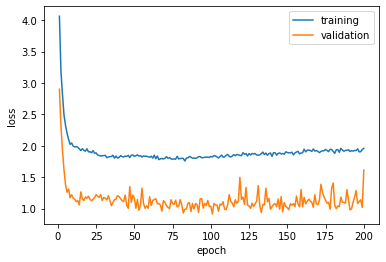

In [100]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [96]:
model.save('unsteady_additive_model')

INFO:tensorflow:Assets written to: unsteady_additive_model\assets
